In [ ]:
from typing import Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

In [ ]:
plt.style.use("fast")
# Seed for reproducibility of the visualization data
np.random.seed(42)
colors = ["#f2431f", "blue"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2)

# Introduction

We are given a Dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}),\ldots, (x^{(n)}, y^{(n)})\}$, where the $x^{(i)} \in \mathbb{R}^2$ are the inputs and $y^{(i)} ∈ \{0, 1\}$ are the labels assigned to point $x^{(i)}$. Our goal is to find the parameters $\theta$ of a linear model $\theta_1 x_1 + \theta_2 x_2 + \theta_3$ that separates between points of both classes. The probability of a label $y$ given a point $x$ in this model is

$$p(y = 1|x, \theta) = sigmoid(\theta_1 x_1 +\theta_2 x_2 + \theta_3)$$

In [170]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Compute the sigmoid function.

    Parameters:
        z (float or np.ndarray): Input value or array of values.

    Returns:
        float or np.ndarray: Sigmoid of the input.
    """
    return 1 / (1 + np.exp(-z))

In [171]:
def neg_log_likelihood(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    """
    Compute the negative log-likelihood for a logistic regression model.

    Parameters:
    theta (np.ndarray): Parameters of the logistic regression model.
    X (np.ndarray): Input features, where each row represents a data point and each column represents a feature.
    y (np.ndarray): True labels for the input data, where each element is 0 or 1.

    Returns:
    float: The negative log-likelihood of the logistic regression model given the parameters theta.
    """
    z = X @ theta
    # To avoid log(0), clip values
    epsilon = 1e-9
    p = sigmoid(z)
    p = np.clip(p, epsilon, 1 - epsilon)
    # Compute negative log-likelihood
    nll = -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    return nll

In [172]:
def grad_neg_log_likelihood(
    theta: np.ndarray, X: np.ndarray, y: np.ndarray
) -> np.ndarray:
    """
    Compute the gradient of the negative log-likelihood for a logistic regression model.

    Parameters:
    theta (np.ndarray): Parameters of the logistic regression model.
    X (np.ndarray): Input features, where each row represents a data point and each column represents a feature.
    y (np.ndarray): True labels for the input data, where each element is 0 or 1.

    Returns:
    np.ndarray: The gradient of the negative log-likelihood with respect to the parameters theta.
    """
    z = X @ theta
    p = sigmoid(z)
    gradient = X.T @ (p - y)
    return gradient

In [173]:
def generate_data(n_samples: int = 200) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic dataset for binary classification.

    Parameters:
        n_samples (int): Total number of samples to generate (default is 200).

    Returns:
        X (ndarray): Feature matrix of shape (n_samples, 2).
        y (ndarray): Label vector of shape (n_samples,).

    The function generates two classes from multivariate normal distributions:
        - Class 0: mean [2, 2], covariance [[1, 0.75], [0.75, 1]]
        - Class 1: mean [0, 0], covariance [[1, 0.75], [0.75, 1]]
    """
    # Class 0 data
    mean0 = [2, 2]
    cov0 = [[1, 0.75], [0.75, 1]]
    X0 = np.random.multivariate_normal(mean0, cov0, n_samples // 2)
    y0 = np.zeros(n_samples // 2)
    # Class 1 data
    mean1 = [0, 0]
    cov1 = [[1, 0.75], [0.75, 1]]
    X1 = np.random.multivariate_normal(mean1, cov1, n_samples // 2)
    y1 = np.ones(n_samples // 2)
    # Combine the data
    X = np.vstack((X0, X1))
    y = np.hstack((y0, y1))
    return X, y

In [180]:
def plot_decision_boundary(X: np.ndarray, y: np.ndarray, thetas: np.ndarray) -> None:
    """
    Plots the decision boundary for logistic regression along with the data points.

    Parameters:
    X: np.ndarray
        The input features, a numpy array of shape (m, n).
    y: np.ndarray
        The true labels, a numpy array of shape (m,).
    theta: np.ndarray
        The parameters of the logistic regression model, a numpy array of shape (n+1,).
    """
    # Create a grid of values
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x1v, x2v = np.meshgrid(
        np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200)
    )

    # Flatten the grid to pass into model
    grid = np.c_[x1v.ravel(), x2v.ravel()]
    grid_augmented = np.hstack([grid, np.ones((grid.shape[0], 1))])

    plt.figure(figsize=(10, 6))

    color = "black" if len(thetas) == 1 else "red"

    for _, theta in enumerate(thetas):
        # Compute probabilities
        probs = sigmoid(grid_augmented @ theta).reshape(x1v.shape)
        # Plot the decision boundary where probability is 0.5
        plt.contour(
            x1v, x2v, probs, levels=[0.5], colors=color, alpha=0.9, linewidths=2
        )

    if len(thetas) == 1:
        plt.contourf(
            x1v, x2v, probs, alpha=0.8, levels=np.linspace(0, 1, 20), cmap="seismic"
        )
        plt.colorbar(label="Probability of class 1")

    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.8)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")
    plt.show()


In [ ]:
# Generate synthetic data
estimated_thetas = []

n_samples = 100

X, y = generate_data(n_samples)

# Augment X with bias term
X_augmented = np.hstack([X, np.ones((n_samples, 1))])

# Initialize parameters
initial_theta = np.zeros(X_augmented.shape[1])

# Optimize the negative log-likelihood
result = minimize(
    fun=neg_log_likelihood,
    x0=initial_theta,
    args=(X_augmented, y),
    method="BFGS",
    jac=grad_neg_log_likelihood,
    options={"disp": False},
)

# Estimated parameters
estimated_theta = result.x
estimated_thetas.append(estimated_theta)

print(f"Estimated theta: {estimated_theta}")


Optimization terminated successfully.
         Current function value: 33.037981
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Estimated theta: [-1.31221243 -1.10052319  2.62021617]


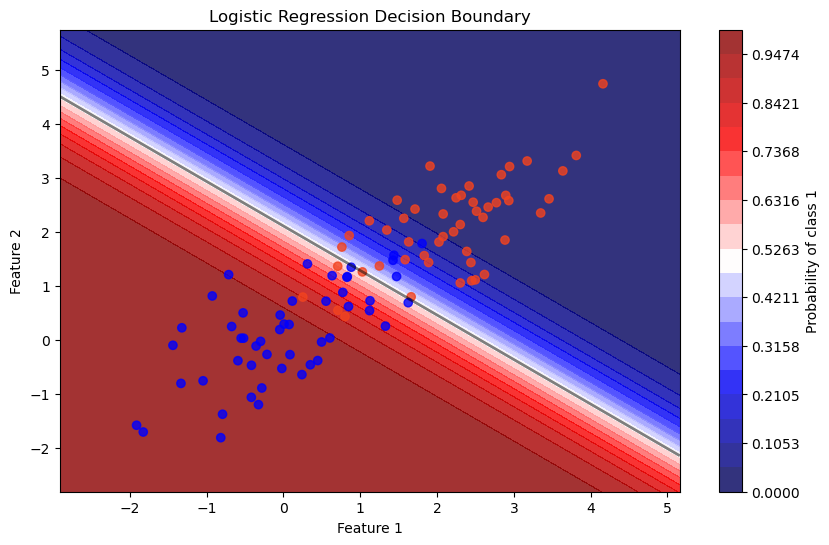

In [176]:
# Plot the decision boundary
plot_decision_boundary(X, y, [estimated_theta])

Experiment 1: Estimated theta: [-0.41795207 -1.35910429  1.67773567]
Experiment 2: Estimated theta: [-1.44372221 -0.80339206  2.21926315]
Experiment 3: Estimated theta: [-1.38972139 -1.06340376  2.08446736]
Experiment 4: Estimated theta: [-1.29636372 -1.04778375  1.87532881]
Experiment 5: Estimated theta: [-0.88039481 -1.80651689  2.82479581]
Experiment 6: Estimated theta: [-0.3579942  -1.75859376  1.95295566]
Experiment 7: Estimated theta: [-1.12273036 -1.24426542  2.28130101]
Experiment 8: Estimated theta: [-1.48916976 -0.62171749  2.2426749 ]
Experiment 9: Estimated theta: [-1.44927318 -1.15108184  2.96847933]
Experiment 10: Estimated theta: [-1.32354184 -0.7428698   2.04764609]
Experiment 11: Estimated theta: [-0.29477127 -2.81176744  3.18373139]
Experiment 12: Estimated theta: [-1.58799328 -2.06112258  3.39510222]
Experiment 13: Estimated theta: [-1.40002625 -0.79778372  2.137362  ]
Experiment 14: Estimated theta: [-1.51157427 -1.01282044  3.10449209]
Experiment 15: Estimated thet

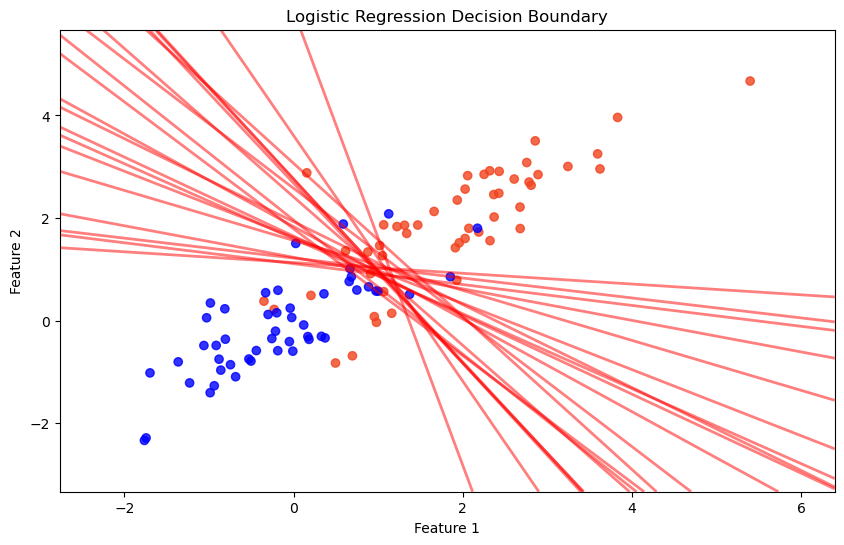

In [ ]:
# Initialize list to store estimated thetas
estimated_thetas = []

# Number of experiments
num_experiments = 20

# Number of samples in each experiment
n_samples = 100

# Generate data once for plotting
X_plot, y_plot = generate_data(n_samples=n_samples)

# Begin experiments
for i in range(num_experiments):
    # Generate synthetic data for each experiment
    X, y = generate_data(n_samples=n_samples)

    # Augment X with bias term
    X_augmented = np.hstack([X, np.ones((X.shape[0], 1))])

    # Initialize parameters (optional: random initialization for diversity)
    initial_theta = np.zeros(X_augmented.shape[1])
    # initial_theta = np.random.randn(
    #     X_augmented.shape[1]
    # )  # Uncomment for random initialization

    # Optimize the negative log-likelihood
    result = minimize(
        fun=neg_log_likelihood,
        x0=initial_theta,
        args=(X_augmented, y),
        method="BFGS",
        jac=grad_neg_log_likelihood,
        options={"disp": False},
    )

    # Estimated parameters
    estimated_theta = result.x
    estimated_thetas.append(estimated_theta)

    print(f"Experiment {i+1}: Estimated theta: {estimated_theta}")


# Plot the decision boundaries
plot_decision_boundary(X_plot, y_plot, estimated_thetas)

**Optional Enhancements:**

- **Random Initialization:**
  - To observe the effect of different initial parameters, uncomment the line:
    ```python
    initial_theta = np.random.randn(X_augmented.shape[1])
    ```
  - This will introduce variability due to initial parameter estimates.

- **Fixed Data Across Experiments:**
  - If you want to isolate the effect of estimation variability (e.g., due to optimization starting points) rather than data variability:
    - Move `X, y = generate_data()` outside the loop so that the same data is used in all experiments.
    - This allows you to see how different initializations affect the estimated parameters with the same data.